<a href="https://colab.research.google.com/github/sumanbhattarai58/Deeplearning_with_pytorch/blob/main/Optimize_fashion_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimizing the fashion mnist neural network.
1. Dropouts
2. Batch Normalization
3. Regularization (l2)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
#set random seeds for reproducibility
torch.manual_seed(42)

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
data = pd.read_csv('fashionmnist_small.csv')
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 35.9 MB


In [ ]:
data.isnull().sum()

,0
label,0
pixel1,0
pixel2,0
pixel3,0
pixel4,0
...,...
pixel780,0
pixel781,0
pixel782,0
pixel783,0


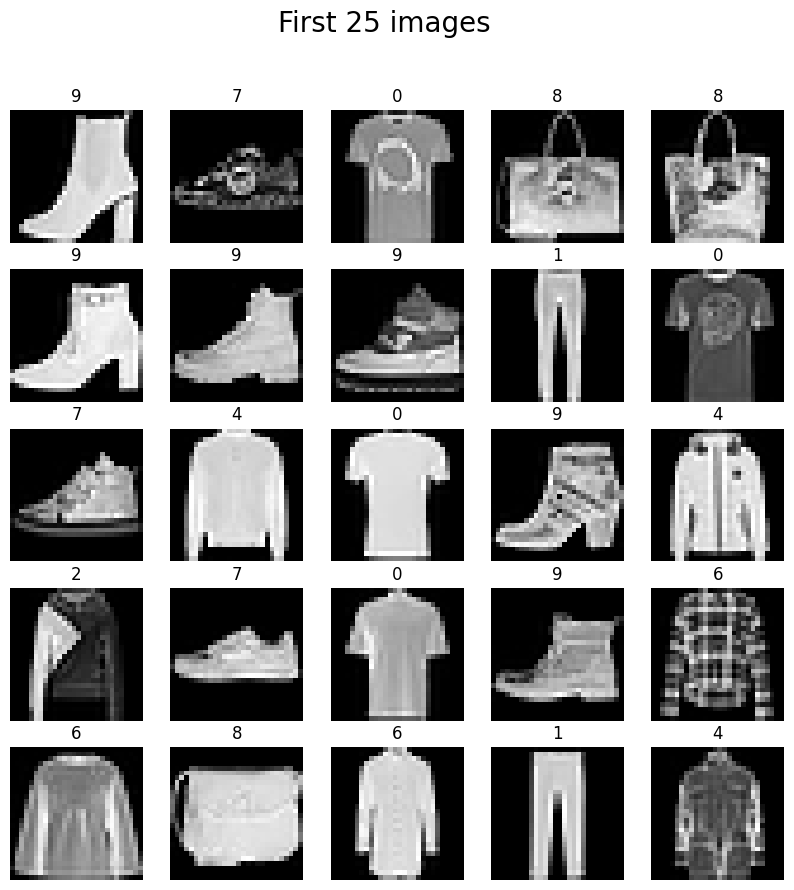

In [ ]:
#create 5*5 grid of images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("First 25 images", fontsize=20)

#plot the first 25 images from the dataset
for i, ax in enumerate(axes.flat):
    img =data.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(data.iloc[i, 0])

plt.show()

In [ ]:
#train-test split
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

In [ ]:
print(X)
print('-'*50)
print(y)

[[  0   0   0 ... 165   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
--------------------------------------------------
[9 7 0 ... 8 4 8]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [ ]:
# scaling the feautures
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train.shape

(4800, 784)

In [ ]:
X_train.shape[1]

784

In [ ]:
#Create customdateset class
class fashiondataset(Dataset):
  def __init__(self,features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
     return self.features[index], self.labels[index]

In [ ]:
#create train_dataset object
train_dataset = fashiondataset(X_train, y_train)

In [ ]:
train_dataset[1]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3451, 0.7686, 0.5961, 0.6235, 0.6235, 0.6196, 0.6157, 0.6157, 0.7647,
         0.5098, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.9176, 0.9922, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9843,
         0.9373, 0.9529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0196, 1.0000, 0.8745, 0.8431, 0.8588, 0.8706, 0.8510, 0.8549,
         0.8588, 0.8588, 1.0000, 0.0510, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.3333, 1.0000, 0.9255, 0.9333, 0.8784, 0.9020, 0.9020,
         0.8980, 0.8941, 0.8627, 1.0000, 0.2706, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [ ]:
#Create train and test data loader
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=50, shuffle=False)

In [ ]:
#Define Neural Network Class
class neuralnetwork(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.BatchNorm1d(128),  #(Using Batch Normalization)
        nn.ReLU(),
        nn.Dropout(0.3),     #(Using Dropouts)
        nn.Linear(128,64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64,10)
    )

  def forward(self, X):
    return self.model(X)


In [ ]:
#set learning rate and epochs
learning_rate = 0.1
epochs =100

In [ ]:
#create a model object
model = neuralnetwork(X_train.shape[1])
model.to(device)     #use of GPU

#loss function
loss_fn= nn.CrossEntropyLoss()

#optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [ ]:
len(train_loader)

96

In [ ]:
#training loop
for epoch in range(epochs):
  total_epoch_loss = 0.0
  for batch_features, batch_labels in train_loader:

    #move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    #forward pass
    outputs = model(batch_features)

    #calculate loss
    loss = loss_fn(outputs, batch_labels)

    #back pass
    optimizer.zero_grad()
    loss.backward()

    #update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 1.0142754043142002
Epoch: 2 , Loss: 0.6942223599180579
Epoch: 3 , Loss: 0.6160049752021829
Epoch: 4 , Loss: 0.5577106416846315
Epoch: 5 , Loss: 0.5363620910793543
Epoch: 6 , Loss: 0.4956411626189947
Epoch: 7 , Loss: 0.4822050317501028
Epoch: 8 , Loss: 0.45292559328178567
Epoch: 9 , Loss: 0.4541981207827727
Epoch: 10 , Loss: 0.4198312172666192
Epoch: 11 , Loss: 0.39277301185453933
Epoch: 12 , Loss: 0.4008911866694689
Epoch: 13 , Loss: 0.39705740194767714
Epoch: 14 , Loss: 0.36152414853374165
Epoch: 15 , Loss: 0.36819234893967706
Epoch: 16 , Loss: 0.3375542432380219
Epoch: 17 , Loss: 0.3405471129032473
Epoch: 18 , Loss: 0.32701040043806034
Epoch: 19 , Loss: 0.3282639909690867
Epoch: 20 , Loss: 0.3022842177500327
Epoch: 21 , Loss: 0.2958052732671301
Epoch: 22 , Loss: 0.28921413111190003
Epoch: 23 , Loss: 0.28750811556043726
Epoch: 24 , Loss: 0.2771874469084044
Epoch: 25 , Loss: 0.26456480581934255
Epoch: 26 , Loss: 0.2630703072063625
Epoch: 27 , Loss: 0.24267133395187557


Evaluation

In [ ]:
# set model to eval mode
model.eval()

neuralnetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    #move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)


0.9922916666666667


In [ ]:
len(test_loader)

96

In [ ]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    #move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)


0.9922916666666667
